# Tutorial: Measuring Group Fairness in Pre-Trial Risk Assessment
**Instructor:** Hilde Weerts

In this tutorial we will explore how we can measure notions of group fairness in Python using [Fairlearn](https://fairlearn.org). As a running example, we consider pre-trial risk assessment scores produced by the COMPAS recidivism risk assessment tool.

---
**Learning Objectives**. After completing this tutorial you will be able to:
* apply group fairness metrics in Python;
* explain several trade-offs between diferent group fairness criteria;
* explain how threats to construct validity may impact downstream fairness-related harms;

---
### COMPAS: A Pre-Trial Risk Assessment Tool
COMPAS is a decision support tool used by courts in the United States to assess the likelihood of a defendant becoming a recidivist; i.e., relapses into criminal behavior. In particular, COMPAS risk scores are used in **pre-trial risk assessment**.

> #### What is pre-trial risk assessment in the US judicial system?
After somebody has been arrested, it will take some time before they go to trial. The primary goal of pre-trial risk assessment is to determine the likelihood that the defendant will re-appear in court at their trial. Based on the assessment, a judge decides whether a defendent will be detained or released while awaiting trial. In case of release, the judge also decides whether bail is set and for which amount. Bail usually takes the form of either a cash payment or a bond. If the defendant can't afford to pay the bail amount in cash - which can be as high as \$50,000 - they can contract a bondsmen. For a fee, typically around 10\% of the bail, the bondsmen will post the defendant's bail.

> If the defendant cannot afford bail nor a bail bond, they have to prepare for their trial while in jail, which is very difficult*. The time between getting arrested and a bail hearing can take days, weeks, months, or even years. In some cases, the decision is between pleading guilty and going home. Consequently, people who cannot afford bail are much more likely to plead guilty to a crime they did not commit. If the judge's decision is a **false positive**, this has a big impact on the defendant's prospects. On the other extreme, **false negatives** could mean that dangerous individuals are released into society.

Proponents of risk assessment tools argue that they can lead to more efficient, less biased, and more consistent decisions compared to human decision makers. However, concerns have been raised that the scores can replicate historical inequalities. Moreover, critics have argued that even if it is possible to produce a "fair" risk assessment, the mere existence of money bail may still disproprotionally affect those wo cannot afford to pay bail. *I highly recommend checking out this [tutorial](https://facctconference.org/2018/livestream_vh210.html) to get a better understanding of the implications of pre-trial risk assessment.*

#### Propublica's Analysis of COMPAS
In May 2016, investigative journalists of Propublica released a critical analysis of COMPAS. **Propublica's assessment: COMPAS wrongly labeled black defendants as future criminals at almost twice the rate as white defendants**, while white defendants were mislabeled as low risk more often than black defendants ([Propublica, 2016](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)). 

The analysis of COMPAS is likely one of the most well-known examples of algorithmic bias assessments. Within the machine learning research community, the incident sparked a renewed interest in fairness of machine learning models. 

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# measuring fairness
from fairlearn.metrics import (
    MetricFrame,
    make_derived_metric,
    selection_rate,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference,
    equalized_odds_difference,
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

## Load Dataset
For this tutorial we will use the [data](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv) that was collected by ProPublica through public records requests in Broward County, Florida. We will pre-process the data similar to Propublica's analysis.

In [2]:
# load data
data = pd.read_csv("compas-scores-two-years.csv")
# filter similar to propublica
data = data[
    (data["days_b_screening_arrest"] <= 30)
    & (data["days_b_screening_arrest"] >= -30)
    & (data["is_recid"] != -1)
    & (data["c_charge_degree"] != "O")
    & (data["score_text"] != "N/A")
]
# select columns
data = data[["sex", "age", "race", "priors_count", "decile_score", "two_year_recid"]]
# cut-off score 5
data["decile_score_cutoff"] = data["decile_score"] >= 5
# inspect
data.head()

,sex,age,race,priors_count,decile_score,two_year_recid,decile_score_cutoff
0,Male,69,Other,0,1,0,False
1,Male,34,African-American,0,3,1,False
2,Male,24,African-American,4,4,1,False
5,Male,44,Other,0,1,0,False
6,Male,41,Caucasian,14,6,1,True


In [3]:
data.race.unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian',
       'Native American'], dtype=object)

The data now contains the following features:

* *sex*. The defendant's sex, measured as US census sex categories (either *Male* or *Female*).
* *race*. The defendant's race, measured as an adaptation of US census race categories (including *Other*, *African-American*, *Caucasian*, *Hispanic*, *Asian*, *Native American*).
* *age*. The defendant's age on the COMPAS screening date. 
* *decile_score*. The COMPAS score expressed in deciles of the raw risk score. The deciles are obtained by ranking scale scores of a normative group and dividing these scores into ten equal-sized groups. Normative groupss are gender-specific. For example, females are scored against a female normative group. According to [the COMPAS documentation](http://www.northpointeinc.com/files/technical_documents/FieldGuide2_081412.pdf), a decile score of 1-4 is low, 5-7 medium, and 8-10 high.
* *priors_count*. The number of prior charges up to but not including the current offense.
* *two_year_recid*. Recidivism, defined as any *registered* offense that occurred within two years of the COMPAS screening date.
* *decile_score_cutoff*. The binarized COMPAS score based on a cut-off score of 5.

--- 

Let's have a look at the distribution of the demographics.

In [4]:
display(data["sex"].value_counts())
display(data["race"].value_counts())

Male      4997
Female    1175
Name: sex, dtype: int64

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

Clearly, *male* individuals are overrepresented in the dataset compared to *female* individuals, which is consistent with known differences in arrest rates. Additionally, the majority of invididuals are categorized as *African-American* or *Caucasian*. Similar to Propublica, we will limit our analysis to these two largest groups.

> #### Intermezzo: Construct Validity of Sensitive Characteristics
**Construct validity** is a concept from the social sciences that refers to *the extent to which a measurement actually measures the phenomenon we are trying to measure*. Many sensitive characteristics, such as race and gender, are **social constructs**, which are multidimensional and dynamic. As such, there are many different ways to operationalize the construct 'race' as a feature in your data set. For example, dimensions of race include self-reported racial identity, observed appearance-based race, observed interaction-based race, etc. This is important, because [how you measure sensitive group membership changes the conclusions you can draw](https://arxiv.org/abs/1912.03593). The racial categories in the COMPAS dataset are based on those that are used by Broward County Sheriff’s Office. This is not necessarily a valid measurement of race. For example, Hispanic is redefined as a racial category (rather than an ethnicity). Additionally, each individual is labeled with just a single category, whereas some people may identify with multiple races. It is also unclear whether the measurements are the result of self-identification or observed by police officers.

In [5]:
# select two largest groups
data = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]

## Demographic Parity
In a classification scenario, the **selection rate** is the proportion of positive predictions. If selection rates differ across groups, there is a risk of **allocation harm**.

> **Allocation Harm**: the system disproportionally extends or witholds opportunities, resources or information to some groups.

For example, in a hiring scenario, the selection rate of applicants who identify as men may be higher compared to other applicants. The risk of allocation harm is particularly prevalent in cases where historical discrimination has resulted in disparities in the observed data, which are subsequently replicated by the machine learning model.

> **Demographic Parity** holds if, for all values of y and a, $$P(\hat{Y} = y | A = a) = P(\hat{Y} = y | A = a')$$ where $\hat{Y}$ is the output of our model and $A$ the set of sensitive characteristics.

In other words, the output of the model should be **independent** of sensitive group membership. We can quantify the extent to which demographic parity is violated through a fairness metric.

#### When should we use demographic parity as a fairness metric? 
The [underlying assumption about fairness of demographic parity](https://arxiv.org/abs/1609.07236) is  that, **regardless of what the measured target variable says**, either:
1. *Everybody **is** equal*. For example, we may believe that traits relevant for a job are independent of somebody's gender. However, due to social biases in historical hiring decisions, this may not be represented as such in the data.
2. *Everybody **should be** equal*. For example, we may believe that different genders are not equally suitable for the job, but this is due to factors outside of the individual's control, such as lacking opportunities due to social gender norms.

Enforcing demographic parity might lead to differences in treatment across sensitive groups, causing otherwise similar people to be treated differently. For example, two people with the exact same features, apart from race, would get a different score prediction. This can be seen a form of *procedural harm*. Consequently, demographic parity is only a suitable metric if one of the two underlying assumptions (everybody *is* or *should be* equal) holds. A limitation of demographic parity is that it does not put any constraints on the scores. For example, to fulfill demographic parity, you do not have to select the most risky people from different racial groups as long as you pick the same proportion for each group.


--- 

### Measuring Demographic Parity using Fairlearn

We can use Fairlearn's `MetricFrame` class to investigate the selection rate across groups. 

The class has the following parameters: 
* `metrics`: a callable metric (e.g., `selection_rate`, or `false_positive_rate`) or a dictionary of callables
* `y_true` : the ground-truth labels
* `y_pred` : the predicted labels
* `sensitive_features`: the sensitive features. Note that there can be multiple sensitive features.
* `control_features`: the control features. Control features are features for which you'd like to investigate disparaties separately (i.e., "control for"). For example, because you expect the feature can explain some of the observed disparities between sensitive groups.

At initialization, the `MetricFrame` object computes the input metric(s) for each group defined by sensitive features.
* `MetricFrame.bygroup`: a pandas dataframe with the metric value for each group
* `MetricFrame.overall`: a float (or dataframe, if `control_features` are used) with the metric value as computed over the entire dataset

We can also summarize the results of the `MetricFrame` using one of the following methods:
* `MetricFrame.difference()` : return the maximum absolute difference between groups for each metric
* `MetricFrame.ratio()` : return the minimum ratio between groups for each metric.
* `MetricFrame.group_max()` : return the maximum value of the metric over the sensitive features.
* `MetricFrame.group_min()` : return the minimum value of the metric over the sensitive features.

The `MetricFrame` object is useful to do a thorough investigation of disparities. When we have (already) identified a definition of fairness that is relevant in our scenario, we may want to optimize for it during model selection. For this, it can be useful to have a single value that summarizes the disparity in a fairness metric.

We can directly summarize the extent to which demographic parity is violated using `demographic_parity_difference()` metric. This metric can also be used in, for example, a grid search. All fairness metrics in Fairlearn have the following arguments:
* `y_true`
* `y_pred`
* `sensitive_features`
* `method`: the method that is used to summarize the difference or ratio across groups. 
    * `'between_groups'`: aggregate the difference as the max difference between any two groups
    * `'to_overall'`: aggregate the difference as the max difference between any group and the metric value as computed over the entire dataset.
    
There are several predefined metrics, such as `fairlearn.metrics.demographic_parity_difference()` and `fairlearn.metrics.equalized_odds_ratio()`. It is also possible to define your own fairness metric, based on e.g., a scikit-learn performance metric, using `fairlearn.metrics.make_derived_metric()`.

---
In the pre-trial risk assessment scenario, unequal selection rates mean that we predict, on average, recidivism more often for one group than the other. Let's investigate the selection rate of COMPAS.

### *Exercise*: use `MetricFrame` to compute difference in *selection rate*

In [6]:
# compute metrics by group
mf = MetricFrame(
    metrics={"selection rate (COMPAS)": selection_rate},
    y_true=data["two_year_recid"],  # is ignored
    y_pred=data["decile_score_cutoff"],
    sensitive_features=data["race"],
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall)

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

,selection rate (COMPAS)
race,
African-American,0.576063
Caucasian,0.330956


Overall selection rate: 0.48
demographic parity difference: 0.25


### *Exercise*: use `demographic_parity_difference` to compute difference in *selection rate*

In [7]:
# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(
    y_true=data["two_year_recid"],  # y_true is ignored
    y_pred=data["decile_score_cutoff"],
    sensitive_features=data["race"],
    method="between_groups",
)  # summarize as the max difference between any of the groups
print("demographic parity difference: %.2f" % dpd)

demographic parity difference: 0.25


Clearly, **COMPAS' selection rate is higher for African-Americans**.

At this point we may wonder whether this disparity is introduced by COMPAS, or whether can we see a similar pattern in the original data. The selection rate observed in the data is also referred to as **base rate**.

### *Exercise*: use `MetricFrame` to compute difference in *base rate*

In [8]:
# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(
    metrics={"base rate": selection_rate},
    y_true=data["two_year_recid"],  # y_true is ignored
    y_pred=data["two_year_recid"],
    sensitive_features=data["race"],
)
display(mf.by_group)

# summarize demographic parity as the max difference between groups
print("base rate diff: %.2f" % mf.difference(method="between_groups"))

,base rate
race,
African-American,0.52315
Caucasian,0.39087


base rate diff: 0.13


Although the difference is substantially smaller compared to COMPAS' selection rates, the base rates do differ across groups. There are several possible explantions of why these disparities arise in the data:

* **The observed recidivism rates may not represent the actual recidivism rates.** Our target variable considers *re-arrests*, which is only a subset of the true cases of recidivism. It could be the case that the observed disparities reflect racist policing practices, rather than the true crime rate.
* **Social deprivations may have caused the true underlying recidivism rate to be different across groups.** In other words, African-American defendants may truely be more likely to fall back into criminal behavior, due to personal circumstances.

**Note that we cannot know which explanation holds from the data alone!** For this, we need a deeper understanding of the social context and data collection practices.

> #### Intermezzo: Construct Validity of Target Variables
Similar to sensitive characteristics, construct validity is important to consider when you define your target variable. In the context of fairness, [a lack of construct validity in the target variable can be a source of downstream model unfairness](https://arxiv.org/abs/1912.05511).
> * [Healthcare costs can be a biased measurement of healthcare needs](https://science.sciencemag.org/content/366/6464/447.abstract), as costs may reflect patients' economic circumstances rather than their health
> * Historical hiring decisions are not necessarily equivalent to historical employee quality, due to systemic and/or (unconscious) social biases in the hiring process.
> * Observed fraud is only a subsample of actual fraud. If potential cases of fraud are not selected randomly, there is a risk of selection bias. If the selection biass is associated with sensitive group membership, some groups may be overscrutinized causing the observed fraud rate to be inflated.

## Equalized Odds

If error rates differ across groups, there is a risk of **quality-of-service harm**.

> **Quality-of-service Harm**: the algorithm makes more mistakes for some groups than for others. 

For example, in a hiring scenario, we may mistakingly reject strong female candidates more often than strong male candidates. The risk of quality-of-service harm is particularly prevalent if the relationship between the features and target variable is different across groups. The risk is further amplified if less data is available for some groups.  For example, strong candidates for a data science position may have either a quantitative social science background or a computer science background. Now imagine that in the past, hiring managers have mostly hired people with a computer science degree but hardly any social scientists. As a result, a machine learning model could mistakingly penalize people who do not have a computer science degree. If particular groups are overrepresented in the candidate pool of social scientists, the error rates may be be higher for those groups, resulting in a quality-of-service harm.

One way to measure quality-of-service harm is through the [equalized odds](https://arxiv.org/abs/1610.02413) constraint.

> **Equalized Odds** holds if, for all values of y and a, $$P(\hat{Y} = y | A = a, Y = y) = P(\hat{Y} = y | A = a', Y = y)$$ where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.

In other words, the **false positive rate** and **true positive rate** (or, equivalently, **false negative rate**) should be equal across groups. 

#### When should we use equalized odds as a fairness metric?
Equalized odds quantifies the understanding of fairness that we should not make more mistakes for some groups than for other groups. Similar to demographic parity, the equalized odds criterion acknowledges that the relationship between the features and the target may differ across groups and that this should be accounted for. However, as opposed to the *everybody is or should be equal* assumptions of demographic parity, **equalized odds implicitly assumes that the target variable is a good representation of what we are actually interested in**.

--- 
As we have seen in the introduction, a false positive prediction in pre-trial risk assessment can have large consequences for the involved defendant. It may even result in the defendant pleading guilty to a crime they did not commit. Let's compute the false positive rates and false negative rates.

### *Exercise*: use `MetricFrame` and `equalized_odds_difference` to compute difference in *false positive rate* and *false negative rate*

In [9]:
# compute metrics
mf = MetricFrame(
    metrics={
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
    },
    y_true=data["two_year_recid"],
    y_pred=data["decile_score_cutoff"],
    sensitive_features=data[["race"]],
)
display(mf.by_group)

# print differences
for i in mf.difference("between_groups").iteritems():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(
    data["two_year_recid"],
    data["decile_score_cutoff"],
    sensitive_features=data["race"],
    method="between_groups",
)
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
race,,
African-American,0.423382,0.284768
Caucasian,0.220141,0.49635


false positive rate diff: 0.20
false negative rate diff: 0.21
equalized odds diff: 0.21


Similar to Propublica's assessment, we find that **the false positive rate is almost twice as high for African Americans compared to Caucasians**. In other words, African Americans are more often falsely predicted to be re-arrested. At the same time, the false negative rate is much higher for Caucasians, indicating that Caucasians are more often released even though they will re-offend. 

> #### Intermezzo: The Problem of Small Sample Sizes
As we have seen, group fairness metrics heavily rely on the estimation of group statistics such as the selection rate or the false positive rate. In many cases, the number of individuals in the data that belong to a particular subgroup can be very small. For example, the number of Asian and Native Americans in the COMPAS data set is extremely small, comprising of only 31 and 11 instances respectively. With small sample sizes, statistical estimates can become very uncertain. In those cases, it is impossible to even accurately *assess* the risk of fairness-related harms - let alone mitigate them. The problem of small sample sizes is further exacerbated when we consider intersectional subgroups, such as Black women. This is particularly problematic, as harms often accumulate at the intersection of marginalized groups. 

## Equal Calibration

Northpointe, the developers of COMPAS, responded to Propublica's analysis that COMPAS scores are fair because the scores are **equally calibrated** across racial groups. In other words, for each possible risk score, the probability that you belong to a particular class is the same, regardless of the group to which you belong.

> **Equal Calibration** holds if, for all values of y, a, and r $$P(Y = y | A = a, \hat{Y} = y) = P(Y = y | A = a', \hat{Y} = y)$$ where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.

For example, given that an instance is predicted to belong to the negative class, the probability of actually belonging to the negative class is independent of sensitive group membership.  In the binary classification scenario, equal calibration implies that the **positive predictive value** (which is equivalent to *precision*) and **negative predictive value** are equal across groups.


#### When should we use equal calibration as a fairness metric?

Equal calibration quantifies an understanding of fairness that a score should have the same *meaning*, regardless of sensitive group membership. Similar to equalized odds, the underlying assumption is that the target variable is a reasonable representation of what reality looks or should look like. However, as opposed to equalized odds, equal calibration does not acknowledge that the relationship between features and target variable may be different across groups.

As opposed to demographic parity and equalized odds, requiring equal calibration usually does not require an active intervention. That is, we usually get equal calibration "for free" when we use machine learning approaches. As such, learning without explicit fairness constraints often [implicitly optimizes for equal calibration](https://arxiv.org/abs/1808.10013).

--- 

Let's verify Northpointe's claim regarding the calibration of COMPAS scores. The positive predictive value is equivalent to precision, so we can simply use `sklearn.metrics.precision_score`. To compute the negative predictive value, we can define a new function.

In [10]:
# first, we define a function to compute the negative predictie value
def negative_predictive_value_score(y_true, y_pred, **kwargs):
    """
    NPV is not in scikit-learn, but is the same as PPV but with 0 and 1 swapped.
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

### *Exercise*: use `MetricFrame` to compute difference in *positive predictive value* and *negative predictive value*

In [11]:
# compute metrics
mf = MetricFrame(
    metrics={
        "positive predictive value": precision_score,
        "negative predictive value": negative_predictive_value_score,
    },
    y_true=data["two_year_recid"],
    y_pred=data["decile_score_cutoff"],
    sensitive_features=data["race"],
)
display(mf.by_group)

# summarize differences
for i in mf.difference("between_groups").iteritems():
    print("%s diff: %.2f" % i)

,positive predictive value,negative predictive value
race,,
African-American,0.649535,0.648588
Caucasian,0.594828,0.710021


positive predictive value diff: 0.05
negative predictive value diff: 0.06


### Customized Fairness Metrics using `make_derived_metric`
We can also define a custom fairness metric for NPV using `fairlearn.metrics.make_derived_metric`. This function takes the following parameters:
* `metric`: a callable metric.
* `transform` : a string indicating the type of transformation, one of `['difference', 'group_min', 'group_max', 'ratio'`
* `sample_param_names` : a list of parameters names of the underlying metric which should be treated as sample parameters. This defaults to a list with a single entry of `sample_weight` (as used by many scikit-learn metrics). If `None` or an empty list is supplied, then no parameters will be treated as sample parameters.

The function returns a function with the same signature as the supplied metric, but with additional `sensitive_features=` and `method=` arguments. Under the hood, this function uses `MetricFrame` to compute the metric disaggregated per group.

### *Exercise*: use `make_derived_metric` to create a custom fairness metric for NPV and use it to compute the difference

In [12]:
# make derived metric
npv_score_diff = make_derived_metric(
    metric=negative_predictive_value_score, transform="difference"
)

# use the new metric to compute the difference
npvd = npv_score_diff(
    data["two_year_recid"],
    data["decile_score_cutoff"],
    sensitive_features=data["race"],
    method="between_groups",
)
print("npv diff: %.2f" % npvd)

npv diff: 0.06


We can further investigate the calibration of the original COMPAS scores (i.e., before we binarized them using a cut-off value of 5) in more detail by plotting a **calibration curve** for each racial group.

### *Exercise*: plot group-specific calibration curves

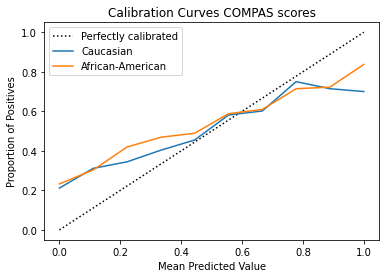

In [13]:
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for race in ["Caucasian", "African-American"]:
    prob_true, prob_pred = calibration_curve(
        y_true=data[data["race"] == race]["two_year_recid"],
        y_prob=data[data["race"] == race]["decile_score"],
        n_bins=10,
        normalize=True,
    )
    plt.plot(prob_pred, prob_true, label=race)
plt.title("Calibration Curves COMPAS scores")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Proportion of Positives")
plt.legend()
plt.show()

Indeed, we see that the calibration curves are similar for both groups, indicating that COMPAS scores are equally calibrated for African-Americans and Caucasians.

## Impossibilities 

In this tutorial, we have seen that some understanding of fairness (equal calibration) holds for COMPAS scores, whereas others (equalized odds and demographic parity) do not. These findings are not specific to the COMPAS case. 

It has been proven mathematically that in cases where *sensitive group membership is **not** independent of the target variable* and the classifier's output is well calibrated, [it is impossible for these three fairness criteria to hold at the same time](https://arxiv.org/pdf/1609.05807.pdf).

* *Demographic Parity and Equal Calibration*. If group membership is related to the target variable, one group has a higher base rate (i.e., proportion of positives) than the other. If we want to enforce demographic parity in this scenario, we need to select more positives in the disadvantaged group than suggested by the observed target outcome. Consequently, the positive predictive value of our classifier will be different for each group, because the proportion of true positives from all instances we predicted to be positive will be lower in the disadvantaged group.

* *Demographic parity and Equalized Odds*. As before, the only way to satisfy demographic parity with unequal base rates is to classify some instances of the disadvantaged group as positives, even if they should be negatives according to the observed target variable. Hence, provided that the scores are well-calibrated, we cannot satisfy both demographic parity and equalized odds at the same time. In a binary scenario, calibration corresponds to using the same cut-off score for each group.

* *Equal Calibration and Equalized Odds*. When a classifier is imperfect, it is impossible to satisfy both equal calibration and equalized odds at the same time. An intuitive explanation of this impossibility is to recall that equal calibration requires equal *positive predictive value* across groups (a.k.a., precision), whereas equalized odds requires equal false negative rate, which corresponds to equal true positive rate (a.k.a. recall). If we adjust our classifier such that the precision is equal across groups, this will decrease the recall, and vice versa.

It is important to realize that **the impossibilities are not so much a mathematical dispute, but a dispute of the underlying theoretical understanding of what we consider fair**. Which notion of fairness is relevant depends on your assumptions about the context and your underlying moral values. In practice, I encourage you to make your assumptions explicit when discussing fairness with other stakeholders.


---
## Challenges and Limitations of Group Fairness Metrics

#### Practical Challenges
* **Identifying sensitive groups**: identifying which groups are at risk for fairness-related harms (and how to measure group membership!) is non-trivial and requires a deep understanding of the sociotechnical context.
* **Access to sensitive features**: due to privacy regulations or practical availability, sensitive features may not be available.
* **Imprecize estimations**: small sample sizes and the problem of multiple comparisons can lead to imprecise estimations of group statistics.

#### Limitations
* **Ignore within-group differences**: group statistics may disguise differences within groups.
* **Merely observational**: group fairness metrics are observational; they do not consider *how* the prediction was achieved (e.g., using which features).
* **Disregard individual experience**: group metrics disregard individual experiences. In practice, some outcomes may not be universally beneficial or harmful. For example, selection rate may not be an adequate measurement of benefit if getting selected is not equally beneficial for each individual.
* **Narrow scope**: group metrics only consider direct outcomes of the model rather than outcomes of the system. For example, the final outcome of the COMPAS model is determined by how judges interpret the provided risk scores.

--- 
## Concluding Remarks
The main take aways of this tutorial are:
* Different **fairness metrics** represent different **theoretical understandings** of fairness, which is reflected in their incompatibility.
* **Construct validity** is central to assessing fairness and should be considered when you define a target variable, measure sensitive group membership, and choose a fairness metric.

### Discussion Points
* What notion of fairness is most appropriate in the pre-trial risk assessment scenario, in your opinion? Why? If you feel like you don't have enough information to answer this question, which information would you need to make an informed judgment?
* A way to account for unequal selection rates is to use a different cut-off score for each group. Note that this policy has the consequence that two defendants with the same risk score but a different race may be classified differently. Under what conditions would you consider such a policy fair, if any? Does your conclusion depend on the underlying source of the bias in the data?
* How equal is equal enough? How much overall performance would you sacrifice for optimizing for a fairness metric, if any?

### Further Resources on Algorithmic Fairness
In addition to the clickable links in the tutorial, the following resources may be helpful:
* [*Fairness and Machine Learning - Limitations and Opportunities*](https://fairmlbook.org) by Solon Barocas, Moritz Hardt, and Arvind Narayanan. 
* [*An Introduction to Algorithmic Fairness*](https://arxiv.org/abs/2105.05595) by yours truly.